In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50


from keras.layers import Input, Add, Dense, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization, Activation, Flatten, ZeroPadding2D, GlobalAveragePooling2D, Dot, Reshape, Conv1D, Concatenate,Multiply, Lambda, UpSampling2D, AveragePooling2D, MaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from time import time
from PIL import Image

import os
import random
import glob

In [2]:
#Training and Test Data path
data_path = "C:\\Users\\User\\Downloads\\Structural Component Recognition\\BridgeComponentClassificationDataset"

training_path = os.path.join(data_path, 'training')
testing_path = os.path.join(data_path,"testing")

train_frames_npy = os.path.join(training_path, 'train_frames_npy')
train_masks_npy = os.path.join(training_path, 'train_masks_npy')

test_frames_npy = os.path.join(testing_path, 'test_frames_npy')
test_masks_npy = os.path.join(testing_path, 'test_masks_npy')

In [3]:
def my_data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder)
    random.shuffle(n)
    
    while(True):
        img = np.zeros((batch_size,256,256,3)).astype('uint8') #uint8: Unsigned integer (0 to 255)
        mask = np.zeros((batch_size,256, 256, 5))
        
        for i in range(c,c+batch_size):
            train_img = np.load(img_folder + f"\\{n[i]}")
            train_img = cv2.resize(train_img, (256,256))

            img[i-c] = train_img
            
            train_mask = np.load(mask_folder + f"\\{n[i]}")
            train_mask = cv2.resize(train_mask, (256,256), interpolation = cv2.INTER_NEAREST)
            train_mask = to_categorical(train_mask, num_classes = 5)
            
            mask[i-c] = train_mask
        
        c+=batch_size
        if (c+batch_size >= len(os.listdir(img_folder))):
            c = 0
            random.shuffle(n)
            
        yield img,mask
    
train_gen = my_data_gen(train_frames_npy, train_masks_npy,16)
val_gen = my_data_gen(test_frames_npy, test_masks_npy,16) 

In [22]:
# Defining Self-attention block
def self_attention(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the self-attention block.
    2. num_channel: Number of channels after the dense operation.
    3. base: layer name identifier.
    """

    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(input_feature)
    dense_1 = Dense(num_channel, name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(input_feature)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    act_2 = Activation('relu', name = base + '/act_2')(dense_2)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    dense_3 = Dense(num_channel, name = base + '/dense_3')(bn_3)
    act_3 = Activation('relu', name = base + '/act_3')(dense_3)

    mul_1 = Multiply(name = base + '/mul_1')([act_2, act_3])
    mask_part = Activation('softmax', name = base + '/act_4')(mul_1)
    mul_2 = Multiply(name = base + '/mul_2')([act_1, mask_part])

    output_feature = Add(name = base + '/add_1')([mul_2, input_feature])

    return output_feature


# Batch of multi-feature attention module
def BMFA(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the BMFA module.
    2. num_channel: Number of channels after the dense operation.
    3. base: layer name identifier.
    """
    out_1 = self_attention(input_feature, num_channel, base + '/self_att_1')
    out_2 = self_attention(input_feature, num_channel, base + '/self_att_2')
    out_3 = self_attention(input_feature, num_channel, base + '/self_att_3')

    output_feature = Add(name = base + '/add')([out_1, out_2, out_3])

    return output_feature

# Parallel excitation module
def PEM(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the PEM module.
    2. num_channel: Number of channels after the convolution operation.
    3. base: layer name identifier.
    """

    # Channel attention
    GAP_output = GlobalAveragePooling2D(name = base + '/gap_layer')(input_feature)
    
    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(GAP_output)
    dense_1 = Dense(int(num_channel/4), name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)
    
    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(act_1)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    
    act_2 = Activation('sigmoid', name = base + '/act_2')(dense_2)
    
    out_channel = Multiply(name = base + '/mul_1')([act_2, input_feature])
    
    # Spatial attention
    strides = (1,1)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    cn_3 = Conv2D(num_channel, (3,3), strides = strides, padding = 'same', name = base + '/conv_1')(bn_3)
    an_3 = Activation('relu', name = base + '/act_3')(cn_3)

    bn_4 = BatchNormalization(axis = -1, name = base + '/bn_4')(an_3)
    cn_4 = Conv2D(1, (1,1), strides = strides, padding = 'same', name = base + '/conv_2')(bn_4)
    cn_4 = Add(name = base + '/sp_add')([input_feature, cn_4])
    
    an_4 = Activation('sigmoid', name = base + '/act_4')(cn_4)

    out_spatial = Multiply(name = base + '/mul_2')([an_4, input_feature])

    output_response = Add(name = base + '/add')([input_feature, out_channel, out_spatial])

    return output_response

#SDAM implementation
def SDAM(input_feature, num_channel, base):
    output_response_PEM = PEM(input_feature, num_channel, base+'_PEM')
    output_feature_BMFA =  BMFA(input_feature, num_channel, base+'_BMFA')
    output_response = Add(name = base + '/add')([output_response_PEM, output_feature_BMFA])
    
    return output_response
    

# Defining Residual Module
def residual_block(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the residual block.
    2. num_channel: Number of channels after the convolution operation.
    3. base: layer name identifier.
    """

    strides = (1,1)

    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(input_feature)
    cn_1 = Conv2D(num_channel, (1,1), strides = strides, padding = 'same', name = base + '/conv_1')(bn_1)
    an_1 = Activation('relu', name = base + '/act_1')(cn_1)
    

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(an_1)
    cn_2 = Conv2D(num_channel, (3,3), strides = strides, padding = 'same', name = base + '/conv_2')(bn_2)
    an_2 = Activation('relu', name = base + '/act_2')(cn_2)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(an_2)
    cn_3 = Conv2D(num_channel, (1,1), strides = strides, padding = 'same', name = base + '/conv_3')(bn_3)
    an_3 = Activation('relu', name = base + '/act_3')(cn_3)

    output_feature = Add(name = base + '/add')([input_feature, an_3])
    
    return output_feature




In [23]:
with tf.device('/cpu:0'):
    def attention_model(n_filters = 16, bn = True, dilation_rate = 1, batch_size = 16):
        inputs = Input(batch_shape=(batch_size, 256, 256, 3))
        conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
        res1 = residual_block(conv1, n_filters * 1, 'base_res1')
        pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(res1)
        
        conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
        res2 = residual_block(conv2, n_filters * 2, 'base_res2')
        
        sdam1 = SDAM(res2, n_filters *2, 'base_SDAM_1')
        
        up1 = UpSampling2D(size=(2, 2))(sdam1)
        conv3 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up1)
        res3 = residual_block(conv3, n_filters * 1, 'base_res3')
        
        finaloutput = Dense(units=5, activation='sigmoid', name='final')(res3)
        model = Model(inputs=inputs, outputs=finaloutput)
        return model

    batch_size = 16
    model = attention_model(n_filters = 32, batch_size = batch_size)

    model.summary()

(16, 128, 128, 64)
(16, 64)
(16, 64)
(16, 16)
(16, 16)
(16, 16)
(16, 64)
(16, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 1)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(16, 256, 256, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (16, 256, 256, 32)   896         ['input_6[0][0]']                
                                                                                                  
 base_res1/bn_1 (BatchNormaliza  (16, 256, 256, 32)  128         ['conv2d_12[0][0]']              
 tion)             

 base_SDAM_1_BMFA/self_att_2/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _3 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _2 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _3 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_PEM/dense_1 (Dense  (16, 16)            1040        ['base_SDAM_1_PEM/bn_1[0][0]']   
 )        

 base_SDAM_1_BMFA/self_att_2/mu  (16, 128, 128, 64)  0           ['base_SDAM_1_BMFA/self_att_2/act
 l_1 (Multiply)                                                  _2[0][0]',                       
                                                                  'base_SDAM_1_BMFA/self_att_2/act
                                                                 _3[0][0]']                       
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/de  (16, 128, 128, 64)  4160        ['base_SDAM_1_BMFA/self_att_3/bn_
 nse_1 (Dense)                                                   1[0][0]']                        
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/mu  (16, 128, 128, 64)  0           ['base_SDAM_1_BMFA/self_att_3/act
 l_1 (Multiply)                                                  _2[0][0]',                       
          

                                                                 _1[0][0]',                       
                                                                  'base_SDAM_1_BMFA/self_att_3/add
                                                                 _1[0][0]']                       
                                                                                                  
 base_SDAM_1/add (Add)          (16, 128, 128, 64)   0           ['base_SDAM_1_PEM/add[0][0]',    
                                                                  'base_SDAM_1_BMFA/add[0][0]']   
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (16, 256, 256, 64)  0           ['base_SDAM_1/add[0][0]']        
                                                                                                  
 conv2d_14 (Conv2D)             (16, 256, 256, 32)   18464       ['up_sampling2d_3[0][0]']        
          

In [33]:
#model evaluation performance matrics 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

smooth = 1

with tf.device('/cpu:0'):
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[dice_coef,'accuracy', iou_coef])

    mc = ModelCheckpoint(mode='max', filepath='att_model_7004.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
    es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
    log_csv = CSVLogger('mylogs_att_7004.csv',separator=',', append=False)
    callbacks = [mc,log_csv]



In [34]:
num_epochs = 100

with tf.device('/gpu:0'):
    result = model.fit(train_gen, steps_per_epoch=int(1329/batch_size) ,
                 epochs=num_epochs, callbacks=callbacks,validation_data = val_gen,
                            validation_steps = int(234/batch_size))

    
    

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 0.1608 - dice_coef: 0.8674 - accuracy: 0.8330 - iou_coef: 0.6454
Epoch 1: accuracy improved from -inf to 0.83303, saving model to att_model_7004.h5
83/83 [==============================] - 28s 306ms/step - loss: 0.1608 - dice_coef: 0.8674 - accuracy: 0.8330 - iou_coef: 0.6454 - val_loss: 0.2117 - val_dice_coef: 0.8092 - val_accuracy: 0.7697 - val_iou_coef: 0.4974
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.1570 - dice_coef: 0.8710 - accuracy: 0.8378 - iou_coef: 0.6512
Epoch 2: accuracy improved from 0.83303 to 0.83783, saving model to att_model_7004.h5
83/83 [==============================] - 24s 294ms/step - loss: 0.1570 - dice_coef: 0.8710 - accuracy: 0.8378 - iou_coef: 0.6512 - val_loss: 0.2346 - val_dice_coef: 0.7687 - val_accuracy: 0.7419 - val_iou_coef: 0.4276
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.1517 - dice_coef: 0.8757 - accuracy: 0.8443 - iou_coef: 

Epoch 21/100
83/83 [==============================] - ETA: 0s - loss: 0.1424 - dice_coef: 0.8841 - accuracy: 0.8544 - iou_coef: 0.6772
Epoch 21: accuracy improved from 0.85273 to 0.85440, saving model to att_model_7004.h5
83/83 [==============================] - 24s 294ms/step - loss: 0.1424 - dice_coef: 0.8841 - accuracy: 0.8544 - iou_coef: 0.6772 - val_loss: 0.1765 - val_dice_coef: 0.8520 - val_accuracy: 0.8110 - val_iou_coef: 0.6208
Epoch 22/100
83/83 [==============================] - ETA: 0s - loss: 0.1443 - dice_coef: 0.8829 - accuracy: 0.8526 - iou_coef: 0.6758
Epoch 22: accuracy did not improve from 0.85440
83/83 [==============================] - 24s 292ms/step - loss: 0.1443 - dice_coef: 0.8829 - accuracy: 0.8526 - iou_coef: 0.6758 - val_loss: 0.2105 - val_dice_coef: 0.8261 - val_accuracy: 0.7827 - val_iou_coef: 0.5785
Epoch 23/100
83/83 [==============================] - ETA: 0s - loss: 0.1415 - dice_coef: 0.8849 - accuracy: 0.8566 - iou_coef: 0.6771
Epoch 23: accuracy impro

Epoch 61/100
83/83 [==============================] - ETA: 0s - loss: 0.1325 - dice_coef: 0.8929 - accuracy: 0.8634 - iou_coef: 0.6970
Epoch 61: accuracy did not improve from 0.86777
83/83 [==============================] - 24s 293ms/step - loss: 0.1325 - dice_coef: 0.8929 - accuracy: 0.8634 - iou_coef: 0.6970 - val_loss: 0.2099 - val_dice_coef: 0.8378 - val_accuracy: 0.7988 - val_iou_coef: 0.6483
Epoch 62/100
83/83 [==============================] - ETA: 0s - loss: 0.1335 - dice_coef: 0.8924 - accuracy: 0.8635 - iou_coef: 0.6945
Epoch 62: accuracy did not improve from 0.86777
83/83 [==============================] - 24s 292ms/step - loss: 0.1335 - dice_coef: 0.8924 - accuracy: 0.8635 - iou_coef: 0.6945 - val_loss: 0.1639 - val_dice_coef: 0.8654 - val_accuracy: 0.8269 - val_iou_coef: 0.6542
Epoch 63/100
83/83 [==============================] - ETA: 0s - loss: 0.1340 - dice_coef: 0.8915 - accuracy: 0.8623 - iou_coef: 0.6937
Epoch 63: accuracy did not improve from 0.86777
83/83 [========

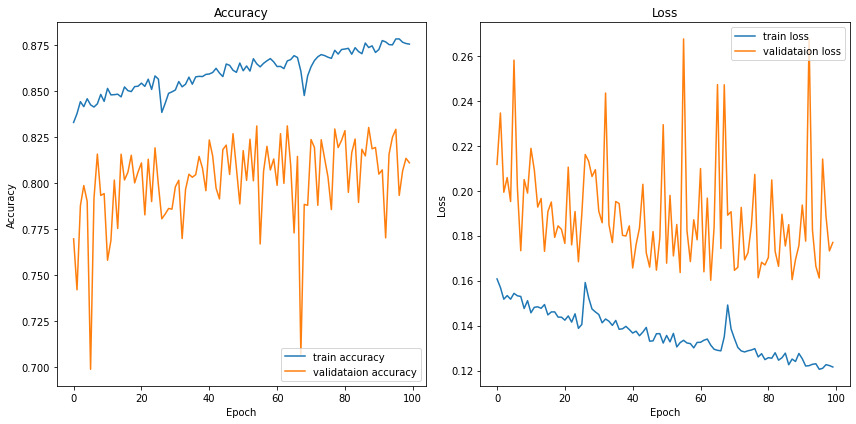

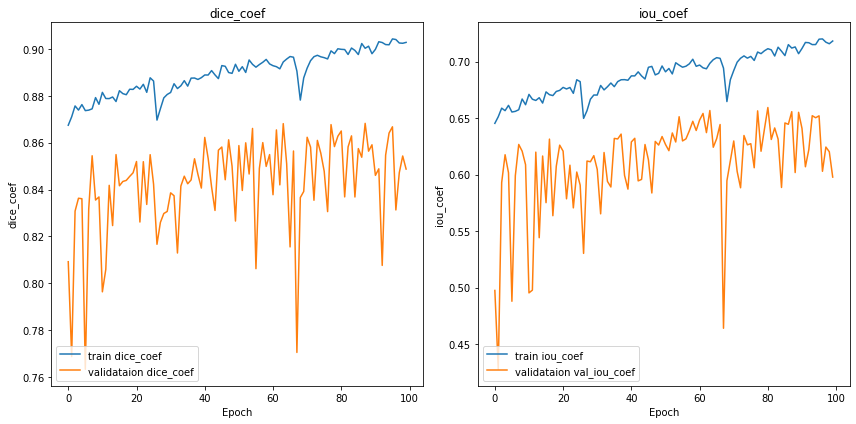

In [39]:
    def display_learning_curves(history):
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]

        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        
        dice_coef = history.history["dice_coef"]
        val_dice_coef = history.history["val_dice_coef"]
        
        iou_coef = history.history["iou_coef"]
        val_iou_coef = history.history["val_iou_coef"]
        
        

        epochs_range = range(num_epochs)
        #print(epochs_range)
        fig = plt.figure(figsize=(12,6))

        plt.subplot(1,2,1)
        plt.plot(epochs_range, acc, label="train accuracy")
        plt.plot(epochs_range, val_acc, label="validataion accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")

        plt.subplot(1,2,2)
        plt.plot(epochs_range, loss, label="train loss")
        plt.plot(epochs_range, val_loss, label="validataion loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")
        

        fig.tight_layout()
        
        
        fig1 = plt.figure(figsize=(12,6))
        
        plt.subplot(1,2,1)
        plt.plot(epochs_range, dice_coef, label="train dice_coef")
        plt.plot(epochs_range, val_dice_coef, label="validataion dice_coef")
        plt.title("dice_coef")
        plt.xlabel("Epoch")
        plt.ylabel("dice_coef")
        plt.legend(loc="lower left")
        
        plt.subplot(1,2,2)
        plt.plot(epochs_range, iou_coef, label="train iou_coef")
        plt.plot(epochs_range, val_iou_coef, label="validataion val_iou_coef")
        plt.title("iou_coef")
        plt.xlabel("Epoch")
        plt.ylabel("iou_coef")
        plt.legend(loc="lower left")
        
        fig1.tight_layout()
        plt.show()


    # Display learning curves 
    display_learning_curves(result)
    
    

1/1 [==============================] - 0s 94ms/step


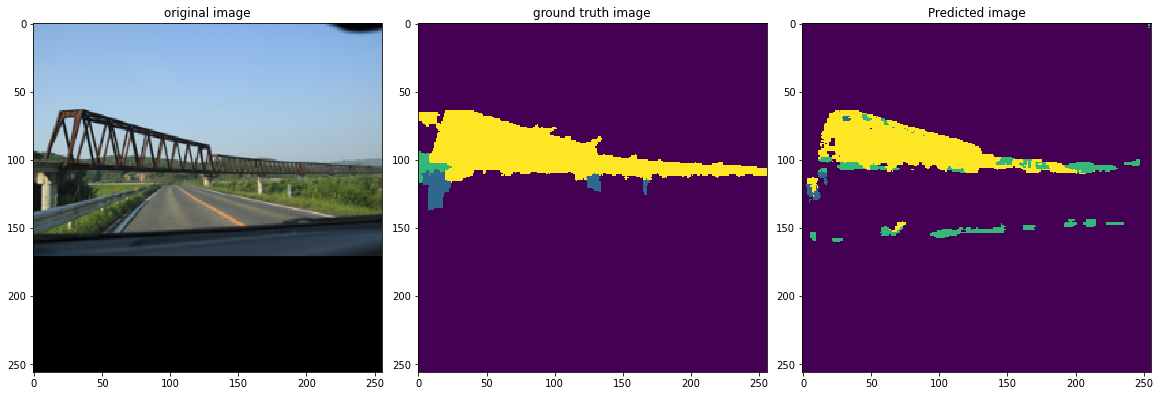

In [52]:
test = next(val_gen)
org = test[0][0]
gt = test[1][0]
gt = np.argmax(gt, axis=-1)
prediction = model.predict(test[0])[0]
pred_mask = tf.argmax(prediction, axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(org, interpolation='none')
axs[0].set_title('original image')
axs[0].grid(False)

axs[1].imshow(gt, interpolation='none' )#cmap='jet')
axs[1].set_title('ground truth image')
axs[1].grid(False)

axs[2].imshow(pred_mask, interpolation='none')#cmap='jet')
axs[2].set_title('Predicted image')
axs[2].grid(False)

plt.show()


In [53]:
a = test[0][0] 
b = test[0]
c = a.reshape(-1,256,256,3)
print(a.shape)
print(b.shape)
print(c.shape)

(256, 256, 3)
(16, 256, 256, 3)
(1, 256, 256, 3)


In [54]:
with tf.device('/cpu:0'):
    from keract import get_activations
    activations = get_activations(model, c,'final')
    

In [55]:
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]


final -> (1, 256, 256, 5) - Numpy array


[None]

final (1, 256, 256, 5) 


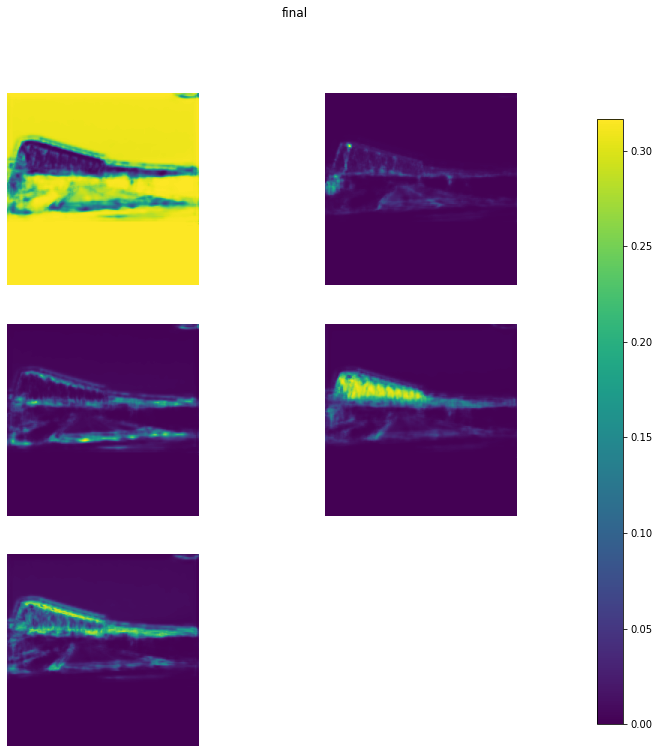

In [57]:
import keract
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(12, 12), reshape_1d_layers=True)



final (1, 256, 256, 5) 


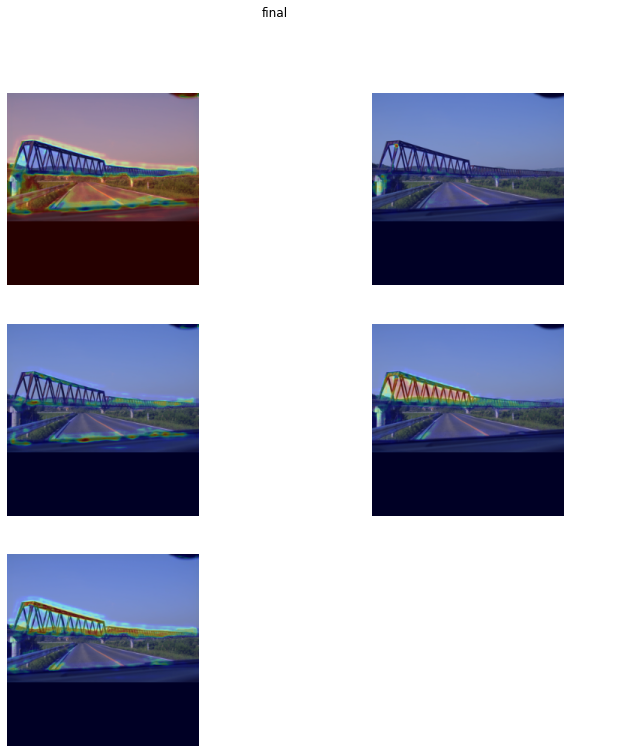

In [58]:
keract.display_heatmaps(activations, a, directory='.', save=False, fix=False, merge_filters=False)


